In [ ]:
# loading imports
import pandas as pd
import numpy as np
from pandas import json_normalize
from matplotlib import pyplot as plt
import json
import codecs
import typing

In [ ]:
# https://stackoverflow.com/questions/21104592/json-to-pandas-dataframe
# loading the cities.json file into a pandas dataframe (like a table)
df = None
with codecs.open("cities.json", encoding="utf-8", mode="r") as read_file:
    data = json.load(read_file)
    df = json_normalize(data)

drops = ["id", "state_id", "state_code", "state_name", "country_id", "country_name"]
for drop in drops:
    df.drop(drop, axis=1, inplace=True)

# merge name and country_name into one column
df["city"] = df["name"] + "-" + df["country_code"]
df.drop("name", axis=1, inplace=True)
df.drop("country_code", axis=1, inplace=True)
# move city column to the front
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

cities = df["city"].tolist()

In [ ]:
from math import radians, cos, sin, sqrt

# https://stackoverflow.com/questions/20654918/python-how-to-speed-up-calculation-of-distances-between-cities

# Constants defined by the World Geodetic System 1984 (WGS84)
A = 6378.137
B = 6356.7523142
ESQ = 6.69437999014 * 0.001


# trying to understand this, it basically makes a point in earth centered earth fixed coordinates
# https://en.wikipedia.org/wiki/ECEF
def geodetic2ecef(lat, lon, alt=0):
    """Convert geodetic coordinates to ECEF."""
    lat, lon = radians(lat), radians(lon)
    xi = sqrt(1 - ESQ * sin(lat))
    x = (A / xi + alt) * cos(lat) * cos(lon)
    y = (A / xi + alt) * cos(lat) * sin(lon)
    z = (A / xi * (1 - ESQ) + alt) * sin(lat)
    return x, y, z


def euclidean_distance(distance):
    """Return the approximate Euclidean distance corresponding to the
    given great circle distance (in km).

    """
    return 2 * A * sin(distance / (2 * B))


ecef_all_cities = [
    geodetic2ecef(float(lat), float(lon))
    for lat, lon in zip(df["latitude"], df["longitude"])
]
min_all = min(ecef_all_cities)
max_all = max(ecef_all_cities)

def distance_to(start: int, end: int) -> float:
    """Return the great circle distance between two cities."""
    start_idx = df.index[start]
    end_idx = df.index[end]
    start_ecef = ecef_all_cities[start_idx]
    end_ecef = ecef_all_cities[end_idx]
    return euclidean_distance(np.linalg.norm(np.array(start_ecef) - np.array(end_ecef)))


In [ ]:
# we make a df with a mapping from city to city containing the distance between them
def distances_of(cities: typing.List[str]) -> pd.DataFrame:
    distances = pd.DataFrame(index=cities, columns=cities)
    for i, city1 in enumerate(cities):
        for j, city2 in enumerate(cities):
            distances.at[city1, city2] = distance_to(i, j)
    return distances

In [ ]:
## V2
import itertools
import typing

# we are using sympy so it cancels out the distance, e.g. (a - b) - (b - a) = 0
import sympy
import pandas as pd


# stores where the teams are at at a given point in time
class Locations:
    at: typing.Dict[sympy.Symbol, sympy.Symbol]

    def copy(self):
        locations = Locations()
        locations.at = self.at.copy()
        return locations


# generates a set of teams and matchups from a number of teams
# capital is a location, lower is a team
class Teams:
    team_count: int
    teams: typing.List[sympy.Symbol]
    locations: typing.List[sympy.Symbol]
    matchups: typing.List[typing.Tuple[sympy.Symbol, sympy.Symbol]]
    distances: pd.DataFrame

    def __init__(self, team_count: int = 4):
        self.team_count = team_count
        self.teams = [sympy.Symbol(chr(97 + i)) for i in range(team_count)]
        self.locations = [sympy.Symbol(chr(65 + i)) for i in range(team_count)]
        # https://stackoverflow.com/questions/104420/how-do-i-generate-all-permutations-of-a-list
        self.matchups = list(itertools.permutations(self.teams, 2))

        self.distances = pd.DataFrame(
            [[start - end for end in self.teams] for start in self.teams],
            columns=self.teams,
            index=self.teams,
        )

    def initial_locations(self) -> Locations:
        locations = Locations()
        locations.at = {
            team: location for team, location in zip(self.teams, self.locations)
        }
        return locations

    # get symbol a from 'a'
    def teamChar(self, char: str) -> str:
        return self.teams[ord(char) - 97]

    def locationChar(self, char: str) -> str:
        return self.locations[ord(char) - 65]

In [123]:
class Plan:
    teams: Teams
    initial_locations: Locations
    travels: typing.List[typing.List[typing.Tuple[sympy.Symbol, sympy.Symbol]]]

    def __init__(self, teams: Teams, initial_locations: Locations):
        self.teams = teams
        self.initial_locations = initial_locations
        self.travels = []
        self.travels.append([])

    def copy(self):
        plan = Plan(self.teams, self.initial_locations)
        plan.travels = self.travels.copy()
        return plan

    def move(self, team: sympy.Symbol, location: sympy.Symbol):
        self.travels[-1].append((team, location))
    
    def next(self):
        self.travels.append([])

    def validate(self) -> bool:
        new_locations = self.initial_locations.copy()
        remaining_games_to_play = set(self.teams.matchups.copy())
        for i, travel in enumerate(self.travels):
            print(f"Travel {i + 1}")
            for team, location in travel:
                new_locations.at[team] = location

            teams_played_already_this_travel = set()

            for team1, team2 in self.teams.matchups:
                matchup = (team1, team2)
                playing_at = self.initial_locations.at[team1]
                if team1 in teams_played_already_this_travel or team2 in teams_played_already_this_travel:
                    continue
                if new_locations.at[team1] == new_locations.at[team2] == playing_at:
                    if matchup in remaining_games_to_play:
                        print(f"Removing {matchup}")
                        remaining_games_to_play.remove(matchup)
                        teams_played_already_this_travel.add(team1)
                        teams_played_already_this_travel.add(team2)

        if len(remaining_games_to_play) > 0:
            print(f"Remaining games to play: {remaining_games_to_play}")
            return False

        # make sure each team is at their own location
        for team, location in new_locations.at.items():
            if location != self.initial_locations.at[team]:
                return False
        return True

In [ ]:
# this is a plan from our team members for 4 teams
team_of_four = Teams(4)
team_of_four_plan = Plan(team_of_four, team_of_four.initial_locations())

four_team_a = team_of_four.teamChar('a')
four_team_b = team_of_four.teamChar('b')
four_team_c = team_of_four.teamChar('c')
four_team_d = team_of_four.teamChar('d')

four_location_A = team_of_four.locationChar('A')
four_location_B = team_of_four.locationChar('B')
four_location_C = team_of_four.locationChar('C')
four_location_D = team_of_four.locationChar('D')

# week 1
team_of_four_plan.move(four_team_a, four_location_B)
team_of_four_plan.move(four_team_c, four_location_D)
team_of_four_plan.next()

# week 2
team_of_four_plan.move(four_team_a, four_location_C)
team_of_four_plan.move(four_team_b, four_location_D)
team_of_four_plan.move(four_team_c, four_location_C)
team_of_four_plan.next()

# week 3
team_of_four_plan.move(four_team_a, four_location_D)
team_of_four_plan.move(four_team_b, four_location_C)
team_of_four_plan.next()

# week 4
team_of_four_plan.move(four_team_a, four_location_A)
team_of_four_plan.move(four_team_b, four_location_B)
team_of_four_plan.move(four_team_c, four_location_B)
team_of_four_plan.move(four_team_d, four_location_A)
team_of_four_plan.next()

# week 5
team_of_four_plan.move(four_team_c, four_location_A)
team_of_four_plan.move(four_team_d, four_location_B)
team_of_four_plan.next()

# week 6
team_of_four_plan.move(four_team_b, four_location_A)
team_of_four_plan.move(four_team_c, four_location_C)
team_of_four_plan.move(four_team_d, four_location_C)
team_of_four_plan.next()

# week 7
team_of_four_plan.move(four_team_b, four_location_B)
team_of_four_plan.move(four_team_d, four_location_D)

print(team_of_four_plan.validate())

Travel 1
Removing (b, a)
Removing (d, c)
Travel 2
Removing (c, a)
Removing (d, b)
Travel 3
Removing (c, b)
Removing (d, a)
Travel 4
Removing (a, d)
Removing (b, c)
Travel 5
Removing (a, c)
Removing (b, d)
Travel 6
Removing (a, b)
Removing (c, d)
Travel 7
True


In [ ]:
# this is my solution for 5 teams, we did this by hand
team_of_five = Teams(5)
team_of_five_plan = Plan(team_of_five, team_of_five.initial_locations())

five_team_a = team_of_five.teamChar('a')
five_team_b = team_of_five.teamChar('b')
five_team_c = team_of_five.teamChar('c')
five_team_d = team_of_five.teamChar('d')
five_team_e = team_of_five.teamChar('e')

five_location_A = team_of_five.locationChar('A')
five_location_B = team_of_five.locationChar('B')
five_location_C = team_of_five.locationChar('C')
five_location_D = team_of_five.locationChar('D')
five_location_E = team_of_five.locationChar('E')

# week 1
team_of_five_plan.move(five_team_b, five_location_A)
team_of_five_plan.move(five_team_d, five_location_C)
team_of_five_plan.next()

# week 2
team_of_five_plan.move(five_team_c, five_location_A)
team_of_five_plan.move(five_team_d, five_location_E)
team_of_five_plan.next()

# week 3
team_of_five_plan.move(five_team_c, five_location_E)
team_of_five_plan.move(five_team_d, five_location_A)
team_of_five_plan.next()

# week 4
team_of_five_plan.move(five_team_b, five_location_B)
team_of_five_plan.move(five_team_c, five_location_D)
team_of_five_plan.move(five_team_d, five_location_B)
team_of_five_plan.move(five_team_e, five_location_A)
team_of_five_plan.next()

# week 5
team_of_five_plan.move(five_team_a, five_location_B)
team_of_five_plan.move(five_team_c, five_location_D)
team_of_five_plan.move(five_team_d, five_location_D)
team_of_five_plan.move(five_team_e, five_location_D)
team_of_five_plan.next()

# week 6
team_of_five_plan.move(five_team_a, five_location_D)
team_of_five_plan.move(five_team_c, five_location_B)
team_of_five_plan.next()

# week 7
team_of_five_plan.move(five_team_a, five_location_C)
team_of_five_plan.move(five_team_e, five_location_B)
team_of_five_plan.move(five_team_c, five_location_C)
team_of_five_plan.next()

# week 8
team_of_five_plan.move(five_team_a, five_location_E)
team_of_five_plan.move(five_team_b, five_location_C)
team_of_five_plan.move(five_team_e, five_location_E)
team_of_five_plan.next()

# week 9
team_of_five_plan.move(five_team_a, five_location_A)
team_of_five_plan.move(five_team_b, five_location_D)
team_of_five_plan.move(five_team_e, five_location_C)
team_of_five_plan.next()

# week 10
team_of_five_plan.move(five_team_e, five_location_D)
team_of_five_plan.move(five_team_b, five_location_E)
team_of_five_plan.next()

# week 11
team_of_five_plan.move(five_team_e, five_location_E)
team_of_five_plan.next()

# week 12 (wrap up)
team_of_five_plan.move(five_team_b, five_location_B)

print(team_of_five_plan.validate())

Travel 1
Removing (a, b)
Removing (c, d)
Travel 2
Removing (a, c)
Removing (e, d)
Travel 3
Removing (a, d)
Removing (e, c)
Travel 4
Removing (a, e)
Removing (b, d)
Travel 5
Removing (b, a)
Removing (d, c)
Travel 6
Removing (b, c)
Removing (d, a)
Travel 7
Removing (b, e)
Removing (c, a)
Travel 8
Removing (c, b)
Removing (e, a)
Travel 9
Removing (c, e)
Removing (d, b)
Travel 10
Removing (d, e)
Travel 11
Removing (e, b)
Travel 12
True


In [126]:
team_of_five_alt = Teams(5)
team_of_five_plan_alt = Plan(team_of_five_alt, team_of_five_alt.initial_locations())

five_team_a_alt = team_of_five_alt.teamChar('a')
five_team_b_alt = team_of_five_alt.teamChar('b')
five_team_c_alt = team_of_five_alt.teamChar('c')
five_team_d_alt = team_of_five_alt.teamChar('d')
five_team_e_alt = team_of_five_alt.teamChar('e')

five_location_A_alt = team_of_five_alt.locationChar('A')
five_location_B_alt = team_of_five_alt.locationChar('B')
five_location_C_alt = team_of_five_alt.locationChar('C')
five_location_D_alt = team_of_five_alt.locationChar('D')
five_location_E_alt = team_of_five_alt.locationChar('E')

# week 1
team_of_five_plan_alt.move(five_team_b_alt, five_location_A_alt)
team_of_five_plan_alt.move(five_team_d_alt, five_location_C_alt)
team_of_five_plan_alt.next()

# week 2
team_of_five_plan_alt.move(five_team_b_alt, five_location_B_alt)
team_of_five_plan_alt.move(five_team_d_alt, five_location_B_alt)
team_of_five_plan_alt.move(five_team_e_alt, five_location_A_alt)
team_of_five_plan_alt.next()

# week 3
team_of_five_plan_alt.move(five_team_c_alt, five_location_B_alt)
team_of_five_plan_alt.move(five_team_d_alt, five_location_A_alt)
team_of_five_plan_alt.move(five_team_e_alt, five_location_E_alt)
team_of_five_plan_alt.next()

# week 4
team_of_five_plan_alt.move(five_team_c_alt, five_location_A_alt)
team_of_five_plan_alt.move(five_team_d_alt, five_location_E_alt)
team_of_five_plan_alt.next()

# week 5
team_of_five_plan_alt.move(five_team_a_alt, five_location_B_alt)
team_of_five_plan_alt.move(five_team_b_alt, five_location_B_alt)
team_of_five_plan_alt.move(five_team_c_alt, five_location_E_alt)
team_of_five_plan_alt.move(five_team_d_alt, five_location_D_alt)
team_of_five_plan_alt.next()

# week 6
team_of_five_plan_alt.move(five_team_a_alt, five_location_C_alt)
team_of_five_plan_alt.move(five_team_c_alt, five_location_C_alt)
team_of_five_plan_alt.move(five_team_e_alt, five_location_D_alt)
team_of_five_plan_alt.next()

# week 7
team_of_five_plan_alt.move(five_team_e_alt, five_location_B_alt)
team_of_five_plan_alt.move(five_team_a_alt, five_location_D_alt)
team_of_five_plan_alt.next()

# week 8
team_of_five_plan_alt.move(five_team_b_alt, five_location_C_alt)
team_of_five_plan_alt.move(five_team_a_alt, five_location_E_alt)
team_of_five_plan_alt.move(five_team_e_alt, five_location_E_alt)
team_of_five_plan_alt.next()

# week 9
team_of_five_plan_alt.move(five_team_a_alt, five_location_A_alt)
team_of_five_plan_alt.move(five_team_b_alt, five_location_E_alt)
team_of_five_plan_alt.move(five_team_c_alt, five_location_D_alt)
team_of_five_plan_alt.next()

# week 10
team_of_five_plan_alt.move(five_team_c_alt, five_location_C_alt)
team_of_five_plan_alt.move(five_team_e_alt, five_location_C_alt)
team_of_five_plan_alt.move(five_team_b_alt, five_location_D_alt)
team_of_five_plan_alt.next()

# week 11
team_of_five_plan_alt.move(five_team_e_alt, five_location_E_alt)
team_of_five_plan_alt.move(five_team_b_alt, five_location_B_alt)

print(team_of_five_plan_alt.validate())

Travel 1
Removing (a, b)
Removing (c, d)
Travel 2
Removing (a, e)
Removing (b, d)
Travel 3
Removing (a, d)
Removing (b, c)
Travel 4
Removing (a, c)
Removing (e, d)
Travel 5
Removing (b, a)
Removing (e, c)
Travel 6
Removing (c, a)
Removing (d, e)
Travel 7
Removing (b, e)
Removing (d, a)
Travel 8
Removing (c, b)
Removing (e, a)
Travel 9
Removing (d, c)
Removing (e, b)
Travel 10
Removing (c, e)
Removing (d, b)
Travel 11
True


In [ ]:
# https://en.wikipedia.org/wiki/Simulated_annealing
# I have no idea what this is but I'm going to research and read about it, 
# apparently you can use it to solve the travelling salesman problem which we are kind of doing

# what I gathered from https://bminaiev.github.io/simulated-annealing
# there's an objective function that we want to minimize, in this case the distance
# then we start with an initial solution
# over many iterations we tweak the solution slightly and if the new solution is better we keep it
# then after a certain number of iterations we stop and return the best solution we found
class Solution:
    plan: Plan
    # map of team to index of city 
    assigned_locations: typing.Dict[sympy.Symbol, int]

    def __init__(self, plan: Plan, location_names: typing.List[str]):
        self.plan = plan
        self.assigned_locations = {
            team_symbonp.where(np.array(cities) == city)[0][0]
            for team_symbol, city in zip(plan.teams.locations, location_names) 
        }

    # want to minimise this
    def score(self) -> float:
        team_distances = dict()
        locations = dict()
        initials = self.plan.teams.initial_locations().at
        for team, location in self.assigned_locations.items():
            locations[team] = self.assigned_locations[team]
            team_distances[team] = 0

        for travel in self.plan.travels:
            for team, location in travel:
                team_home = initials[team]
                old_location =  locations[team_home]
                locations[team_home] = self.assigned_locations[location]
                distance = distance_to(old_location, locations[team_home])
                team_distances[team_home] += distance

        std_diff = np.std(list(team_distances.values()))
        return std_diff

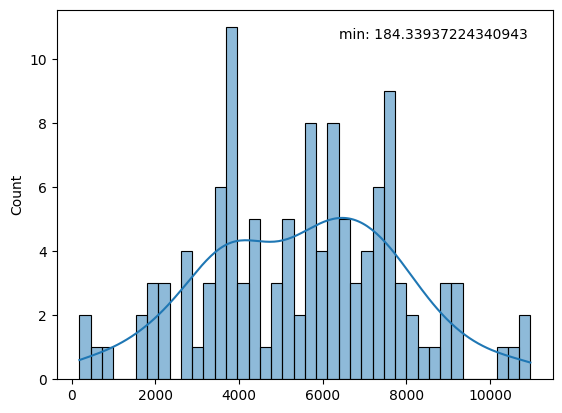

3930.701412241343


In [ ]:
# example case
cities_oceania_east_asia = [
    "Wellington-NZ",
    "Melbourne-AU",
    "Kobe-JP",
    "Amphoe Mueang Buriram-TH",
    "Yokohama-JP",
]

def a_e_for_team(cities: typing.List[str]) -> typing.Tuple[str, str]:
    all_location_permutations = list(itertools.permutations(cities, len(cities)))
    all_solutions = []
    for location_permutation in all_location_permutations:
        annealing = Solution(team_of_five_plan_alt, location_permutation)
        all_solutions.append((location_permutation, annealing.score()))

    return all_solutions

# print(get_best_a_e_for_team(cities_oceania_east_asia))

import seaborn as sns

ae_oce_asia = a_e_for_team(cities_oceania_east_asia)

testing = [
    "Wellington-NZ",
    "Yokohama-JP",
    "Melbourne-AU",
    "Kobe-JP",
    "Amphoe Mueang Buriram-TH",
]
testing_solution = Solution(team_of_five_plan_alt, testing)
print(testing_solution.score())

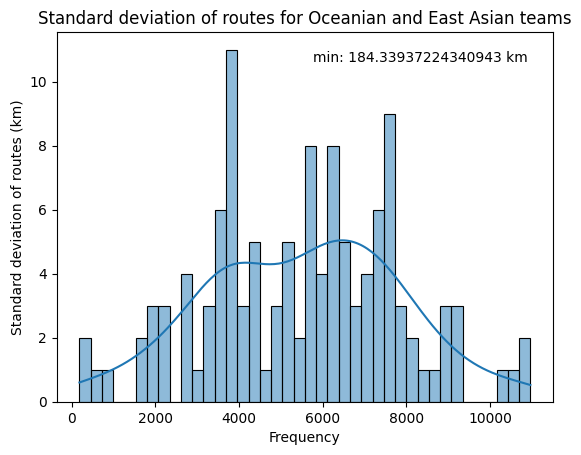

(('Wellington-NZ', 'Amphoe Mueang Buriram-TH', 'Kobe-JP', 'Melbourne-AU', 'Yokohama-JP'), np.float64(184.33937224340943))


In [135]:

# plot them out in a histogram of scores
def plot_scores(scores: typing.List[float]):
    ax = sns.histplot(scores, kde=True, bins=40)
    # also label min and max
    ax.text(0.95, 0.95, f"min: {min(scores)} km", ha='right', va='top', transform=ax.transAxes)
    ax.set_ylabel("Standard deviation of routes (km)")
    ax.set_xlabel("Frequency")
    ax.set_title("Standard deviation of routes for Oceanian and East Asian teams")
    plt.show()

plot_scores([score for _, score in ae_oce_asia])
print(min(ae_oce_asia, key=lambda x: x[1]))